## 0. Initializations and common functions/classes

### Imports

In [1]:

import jax
import jax.numpy as jnp
import jax.random as jr
from diffrax import diffeqsolve, ControlTerm, EulerHeun, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree
import diffrax as dfx
import equinox as eqx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import ScaledTranslation
import numpy as np
import pandas as pd
from diffrax import UnsafeBrownianPath


# Initial stuff
media = ''
qcmap=sns.color_palette('colorblind')
alpha_level = 0.6


### Activation functions

In [2]:

def relu(x):
    return jnp.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def tanh(x):
    return jnp.tanh(x)

def logit(y):
    if y <= 0 or y >= 1:
        raise ValueError("Input must be in the range (0, 1), exclusive.")
    return jnp.log(y / (1 - y))


### Data-related functions

In [3]:


# Decorrelate data
def zca_whitening(X):
    """
    Perform ZCA whitening on a dataset using JAX.
    :param X: The T x N dataset where T is the number of samples and N is the number of features.
    :return: ZCA whitened dataset.
    """
    # Step 1: Center the data (subtract the mean)
    X_mean = jnp.mean(X, axis=0)
    X_centered = X - X_mean

    # Step 2: Compute the covariance matrix
    cov_matrix = jnp.cov(X_centered, rowvar=False)

    # Step 3: Perform eigenvalue decomposition of the covariance matrix
    eigenvalues, eigenvectors = jnp.linalg.eigh(cov_matrix)

    # Step 4: Form the ZCA whitening matrix
    epsilon = 1e-5  # Small constant to prevent division by zero
    D = jnp.diag(1.0 / jnp.sqrt(eigenvalues + epsilon))
    whitening_matrix = eigenvectors @ D @ eigenvectors.T

    # Step 5: Apply ZCA whitening
    X_zca = X_centered @ whitening_matrix

    return X_zca, whitening_matrix, X_mean



# Data reading and preparation
def generate_weather_data(delay_pred=24, split_indx=90000, decorrelation=False, path=''):
    '''
        Hourly climatological data of the Szeged, Hungary area, between 2006 and 2016.
        https://www.kaggle.com/datasets/budincsevity/szeged-weather/data
        Pressure variable has large outliers (usual values are ~1000, outliers are 0)
    '''

    # Read data
    data = pd.read_csv(str(path)+'weatherHistory.csv')
    data = data[['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Pressure (millibars)']].to_numpy().astype('float32')

    # set Wind Bearing to sine and cosine
    data = np.hstack([data[:,:3], np.sin(2*np.pi*data[:, 3]/360)[:, np.newaxis], np.cos(2*np.pi*data[:, 3]/360)[:, np.newaxis], data[:,-1][:, np.newaxis]])
    features_names = ['Temperature (C)', 'Relative humidity', 'Wind speed (km/h)', 'Sine wind bearing', 'Cosine wind bearing', 'Pressure (millibars)']

    # Remove outliers
    data[data[:, -1] == 0.0, -1] = jnp.nan
    df = pd.DataFrame(data)
    data = jnp.array(df.interpolate(method='linear', axis=0, limit_direction='both').to_numpy())

    # ZCA decorrelate data
    if decorrelation:
        data, W_zca, X_mean = zca_whitening(data)

    # Calculate mean and standard deviation
    data_mean = jnp.nanmean(data, axis=0)
    data -= data_mean
    data_std = jnp.nanstd(data, axis=0)
    data /= data_std

    # # Normalize data
    # if not decorrelation:



    # Generate labels
    features = data[:-delay_pred]
    labels = data[delay_pred:, 0]

    # Split train and test
    x_train = features[:split_indx]
    y_train = labels[:split_indx]
    x_test = features[split_indx:]
    y_test = labels[split_indx:]

    return (x_train, y_train), (x_test, y_test), features_names, data_mean, data_std


### Learning algorithm (OUA)

In [4]:


def diffusive_learning(control_fun, reward_fun, y0, dt=0.05, t0=0, t1=200, epsilon=1.0, lambd=1.0, sigma=0.5, eta=1.0, key=jr.PRNGKey(0), target_fun=None):

    @eqx.filter_jit
    def drift_fun(t, y, args):
        '''
            Return deterministic values:
             1) dr̄ = ε(r-r̄) dt
             2) dθ = λ(μ-θ)
             3) dμ = η(r-r̄)(θ-μ)
             4) dr = r -> Cumulative reward
        '''

        # Variable dimension in theta and mu
        N = y.size
        M = int((N - 2) / 2)  
        rbar = y[0]           
        theta = y[1:(M+1)]     
        mu = y[(M+1):(2*M+1)]  
        gain = y[-1]       
        if target_fun is None: 
            r = reward_fun(args[0](t), theta, t)
        else:
            r = reward_fun(args[0](t), theta, args[1](t))
        return jnp.hstack([epsilon * (r - rbar),
                           lambd * (mu - theta),
                           eta * (r - rbar) * (theta - mu),
                           r])  

    # Number of parameters (M)
    N = y0.size
    M = int((N - 2) / 2) 

    # Wiener process (random noise)
    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(M,), key=key)
    
    # Apply noise to theta (2nd output variable)
    D = jnp.vstack([jnp.zeros(M), sigma * jnp.eye(M), jnp.zeros((M, M)), jnp.zeros(M)]) # Diffusion matrix (sort of mask)
    diffusion_fun = lambda t, y, args: D
    noise_func = ControlTerm(diffusion_fun, brownian_motion)
    terms = MultiTerm(ODETerm(drift_fun), noise_func)

    # Numerical integration to simulate system
    solver = EulerHeun()
    if target_fun is None:
        sol = diffeqsolve(terms, solver, t0=t0, t1=t1, dt0=dt, y0=y0, saveat=dfx.SaveAt(steps=True), args=[control_fun], max_steps=100000)
    else:
        sol = diffeqsolve(terms, solver, t0, t1, dt0=dt, y0=y0, saveat=dfx.SaveAt(steps=True), args=[control_fun, target_fun], max_steps=300000)

    # Remove infinite values from the solution
    ts = sol.ts[~jnp.isinf(sol.ts)]
    ys = sol.ys[~jnp.isinf(sol.ts), :]

    return ts, ys



 ## 1. Learning a single-parameter model

### Learn one parameter

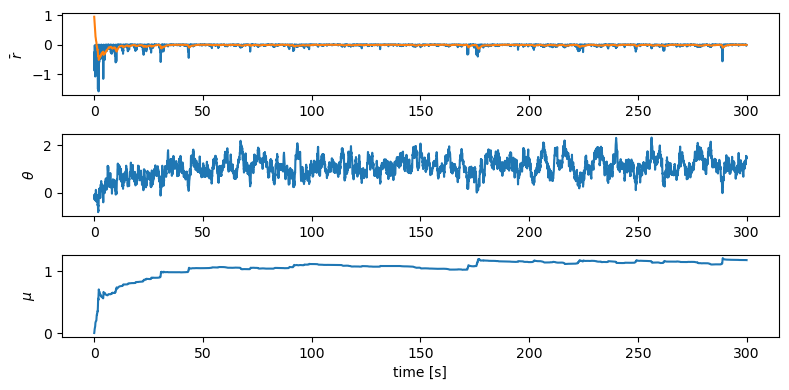

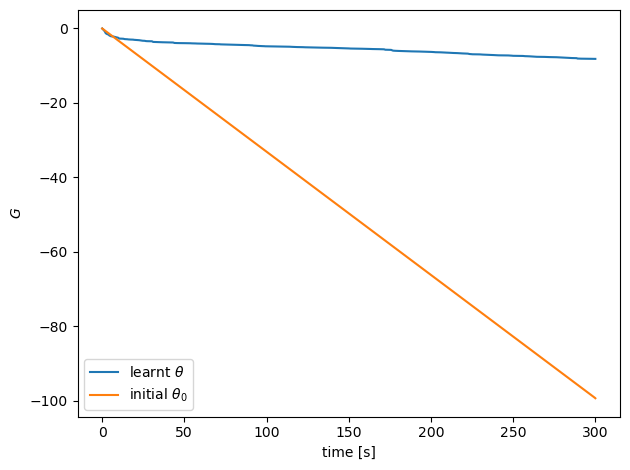

In [10]:

# Reward function
@jax.jit
def reward_fun(u, theta, t):
    '''
        Computes reward as r = -(y - y^*)^2
        with y = u * theta as the prediction and y^* = u * theta_gt as the target
    '''
    theta_gt = 1.0
    return -(tanh(u * theta) - tanh(u * theta_gt)) ** 2


# Control input function - sin wave
control_fun= lambda t: jnp.sin(10.0*t)


# Initial conditions
theta0 = 0.0
mu0 = theta0
rbar0 = 1.0 #0.0
gain0 = 0.0
y0 = jnp.array([rbar0, theta0, mu0, gain0])


# Keys (seeds)
keys = jr.split(jr.PRNGKey(0), 15)
key = keys[0]


# Simulate learning process
ts, ys = diffusive_learning(control_fun, reward_fun, y0, t0=0, t1=300, key=key)


# Plot (i) reward & reward_avg, (ii) theta and (iii) mu during learning
fig, ax = plt.subplots(3,1, figsize=(8,4))
rewards = jax.vmap(reward_fun)(control_fun(ts), ys[:, 1], ts)
ax[0].plot(ts, rewards)
ax[0].plot(ts, ys[:, 0])
ax[0].set_ylabel(r'$\bar{r}$')
ax[1].plot(ts, ys[:, 1])
ax[1].set_ylabel(r'$\theta$');
ax[2].plot(ts, ys[:, 2])
ax[2].set_ylabel(r'$\mu$')
ax[2].set_xlabel('time [s]')
plt.tight_layout()


# Plot cumulative reward
plt.figure()
plt.plot(ts, ys[:, 3])

# Cumulative reward without learning
ts, ys = diffusive_learning(control_fun, reward_fun, y0, t0=0, t1=300, epsilon=0.0, lambd=0.0, sigma=0.0, eta=0.0, key=key)
plt.plot(ts, ys[:,3]) 
plt.ylabel(r"$G$") # we define the gain G as the cumulative reward
plt.xlabel('time [s]')
plt.axis('tight')
plt.legend([r"learnt $\theta$", r"initial $\theta_0$"])
plt.tight_layout()

# NOTE: not used in paper


### Learn one parameter batched

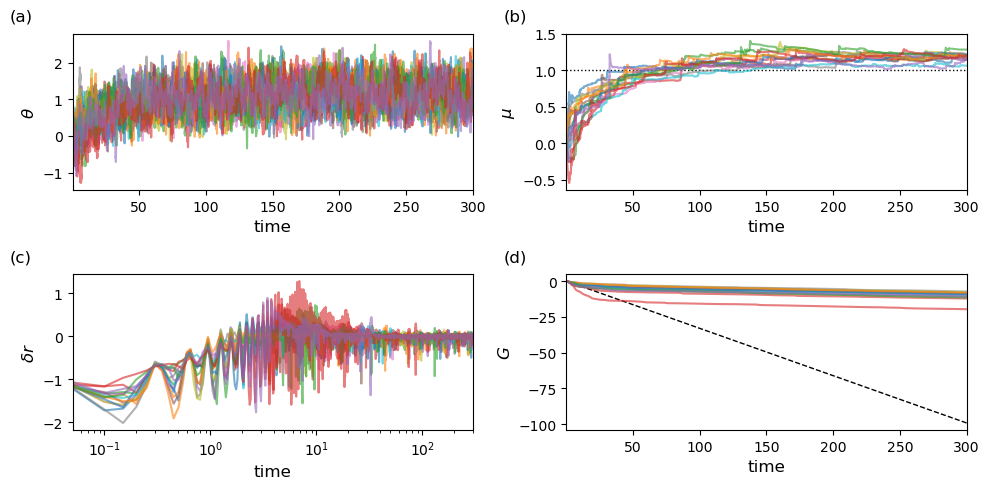

In [12]:

# Initial conditions 
theta0 = 0.0  
mu0 = theta0 
rbar0 = 1.0  
gain0 = 0.0   
y0 = jnp.array([rbar0, theta0, mu0, gain0])  


# Parallel simulations (batched)
N = 15
keys = jr.split(jr.PRNGKey(0), N)
ts, ys = jax.vmap(lambda k : diffusive_learning(control_fun, reward_fun, y0, key=k, t1=300))(keys)


# Extract variables
ts = ts[0]
rbars = ys[:, :, 0].T
thetas = ys[:, :, 1].T
mus = ys[:, :, 2].T
cumrewards = ys[:, :, 3].T


# Create plot
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

# Plot theta 
ax[0, 0].set_xlim([ts[0], ts[-1]]) 
ax[0, 0].plot(ts, thetas, lw=1.5, alpha=alpha_level) 
ax[0, 0].set_xlabel('time', fontsize=12)
ax[0, 0].set_ylabel(r"$\theta$", fontsize=12)
ax[0, 0].text(0.0, 1.0, '(a)', transform=(ax[0, 0].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
               fontsize='large', va='bottom')

# Plot mu 
ax[0, 1].set_xlim([ts[0], ts[-1]]) 
ax[0, 1].plot([ts[0], ts[-1]], [1.0, 1.0], 'k:', lw=1)  
ax[0, 1].plot(ts, mus, lw=1.5, alpha=alpha_level) 
ax[0, 1].set_xlabel('time', fontsize=12)
ax[0, 1].set_ylabel(r"$\mu$", fontsize=12)
ax[0, 1].text(0.0, 1.0, '(b)', transform=(ax[0, 1].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
               fontsize='large', va='bottom')

# Plot RPE 
for i in range(N):  
    rewards = jax.vmap(lambda t, theta: reward_fun(control_fun(t), theta, t))(ts, ys[i, :, 1]) 
    RPE = rewards - ys[i, :, 0]  
    ax[1, 0].semilogx(ts, RPE, lw=1.5, label=r'$\delta_r$', alpha=alpha_level)
ax[1, 0].set_xlabel('time', fontsize=12)
ax[1, 0].set_xlim(ts[0], ts[-1]) 
ax[1, 0].set_ylabel(r'$\delta r$', fontsize=12)
ax[1, 0].text(0.0, 1.0, '(c)', transform=(ax[1, 0].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
               fontsize='large', va='bottom')


# Plot cumulative reward 
ax[1, 1].set_xlim([ts[0], ts[-1]])  

# Cumulative reward without learning 
ts0, ys0 = diffusive_learning(control_fun, reward_fun, y0, t0=0, t1=300, epsilon=0.00, lambd=0.0, sigma=0.0, eta=0.0, key=jr.PRNGKey(0))
ax[1, 1].plot(ts0, ys0[:,3], 'k--', lw=1) 
ax[1, 1].plot(ts, cumrewards, lw=1.5, alpha=alpha_level)
ax[1, 1].set_xlabel('time', fontsize=12)
ax[1, 1].set_ylabel(r"$G$", fontsize=12)
ax[1, 1].text(0.0, 1.0, '(d)', transform=(ax[1, 1].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
               fontsize='large', va='bottom')

# End plot stuff
plt.tight_layout()
plt.savefig(media+'one_parameter_learning.pdf', format='pdf')


### Sensitivity analysis

maximum lambda: 2.0
maximum sigma: 0.44444445
maximum epsilon: 0.0
maximum eta: 1.3333334


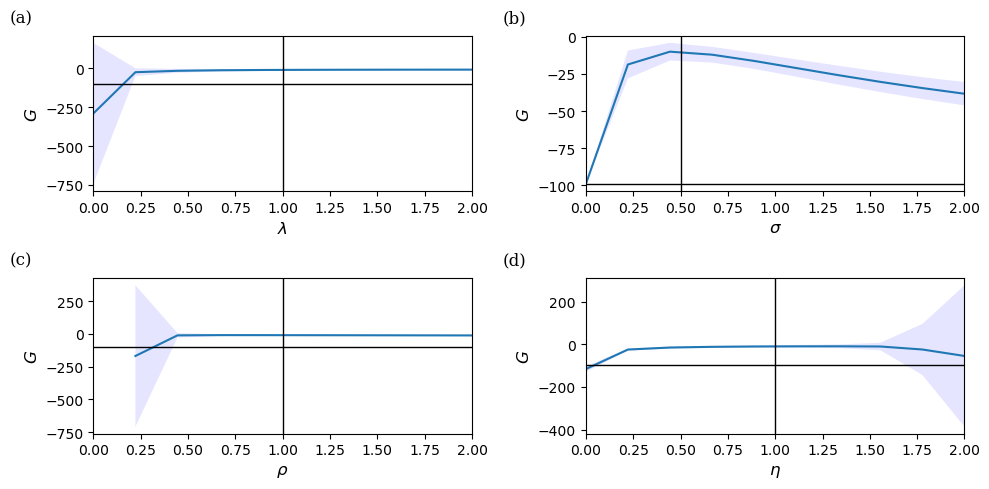

In [25]:

def sweep(pname, params, control_fun, reward_fun, N):
    '''
        Parameter sensitivity analysis by simulating
        learning for different variables values  
    '''

    # Initial conditions
    theta0 = 0.0  
    mu0 = theta0  
    rbar0 = 1.0  
    y0 = jnp.array([rbar0, theta0, mu0, 0.0]) 

    # Keys (seeds)
    keys = jr.split(jr.PRNGKey(0), N)
   
    # Iterate values variable
    pvals = []  
    for p_ in params: 
        if pname == 'lambd':
            ts, ys = jax.vmap(lambda k: diffusive_learning(control_fun, reward_fun, y0, key=k, t1=300, lambd=p_))(keys)
        elif pname == 'sigma':
            ts, ys = jax.vmap(lambda k: diffusive_learning(control_fun, reward_fun, y0, key=k, t1=300, sigma=p_))(keys)
        elif pname == 'epsilon':
            ts, ys = jax.vmap(lambda k: diffusive_learning(control_fun, reward_fun, y0, key=k, t1=300, epsilon=p_))(keys)
        elif pname == 'eta':
            ts, ys = jax.vmap(lambda k: diffusive_learning(control_fun, reward_fun, y0, key=k, t1=300, eta=p_))(keys)
        else:
            raise ValueError(f"Unknown parameter {pname}")

        # Store cumulative reward
        pvals.append(ys[:, -1, 3]) 

    return jnp.array(pvals) 


# Define variables ranges
lambda_params = jnp.linspace(0.0, 2.0, 10)  
sigma_params = jnp.linspace(0.0, 2.0, 10) 
epsilon_params = jnp.linspace(0.0, 2.0, 10) 
eta_params = jnp.linspace(0.0, 2.0, 10) 


# Simulate and evaluate cumulative reward
lambda_vals = sweep('lambd', lambda_params, control_fun, reward_fun, N=15)  
sigma_vals = sweep('sigma', sigma_params, control_fun, reward_fun, N=15)  
epsilon_vals = sweep('epsilon', epsilon_params, control_fun, reward_fun, N=15)  
eta_vals = sweep('eta', eta_params, control_fun, reward_fun, N=15) 


# Plot cumulative rewards
fig, ax = plt.subplots(2, 2, figsize=(10, 5))


# Results for lambda
ax[0, 0].set_xlim([jnp.min(lambda_params), jnp.max(lambda_params)])  
lambda_mean = jnp.mean(lambda_vals, axis=1)  
lambda_sd = jnp.std(lambda_vals, axis=1)  
ax[0, 0].fill(jnp.concatenate([lambda_params, lambda_params[::-1]]),
               jnp.concatenate([lambda_mean - 1.9600 * lambda_sd, (lambda_mean + 1.9600 * lambda_sd)[::-1]]),
               alpha=.1, fc='b', ec='None')  
ax[0, 0].plot(lambda_params, lambda_mean, lw=1.5) 
ax[0, 0].set_xlabel(r"$\lambda$", rotation=0, fontsize=12) 
ax[0, 0].set_ylabel(r"$G$", fontsize=12)  
ax[0, 0].text(0.0, 1.0, '(a)', transform=(
    ax[0, 0].transAxes + ScaledTranslation(-60/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif') 
ax[0, 0].axvline(x=1.0, color='black', linewidth=1) 
ax[0, 0].axhline(y=ys0[-1, 3], color='black', linewidth=1) 


# Results for sigma
ax[0, 1].set_xlim([jnp.min(sigma_params), jnp.max(sigma_params)]) 
sigma_mean = jnp.mean(sigma_vals, axis=1) 
sigma_sd = jnp.std(sigma_vals, axis=1) 
ax[0, 1].fill(jnp.concatenate([sigma_params, sigma_params[::-1]]),
               jnp.concatenate([sigma_mean - 1.9600 * sigma_sd, (sigma_mean + 1.9600 * sigma_sd)[::-1]]),
               alpha=.1, fc='b', ec='None') 
ax[0, 1].plot(sigma_params, sigma_mean, lw=1.5) 
ax[0, 1].set_xlabel(r"$\sigma$", rotation=0, fontsize=12) 
ax[0, 1].set_ylabel(r"$G$", fontsize=12) 
ax[0, 1].text(0.0, 1.0, '(b)', transform=(
    ax[0, 1].transAxes + ScaledTranslation(-60/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif') 
ax[0, 1].axvline(x=0.5, color='black', linewidth=1)  
ax[0, 1].axhline(y=ys0[-1, 3], color='black', linewidth=1) 


# Results for epsilon
ax[1, 0].set_xlim([jnp.min(epsilon_params), jnp.max(epsilon_params)])  
epsilon_mean = jnp.mean(epsilon_vals, axis=1) 
epsilon_sd = jnp.std(epsilon_vals, axis=1)  
ax[1, 0].fill(jnp.concatenate([epsilon_params, epsilon_params[::-1]]),
               jnp.concatenate([epsilon_mean - 1.9600 * epsilon_sd, (epsilon_mean + 1.9600 * epsilon_sd)[::-1]]),
               alpha=.1, fc='b', ec='None')  
ax[1, 0].plot(epsilon_params, epsilon_mean, lw=1.5) 
ax[1, 0].set_xlabel(r"$\rho$", rotation=0, fontsize=12) 
ax[1, 0].set_ylabel(r"$G$", fontsize=12)  
ax[1, 0].text(0.0, 1.0, '(c)', transform=(
    ax[1, 0].transAxes + ScaledTranslation(-60/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif') 
ax[1, 0].axvline(x=1.0, color='black', linewidth=1)  
ax[1, 0].axhline(y=ys0[-1, 3], color='black', linewidth=1) 


# Results for eta
ax[1,1].set_xlim([jnp.min(eta_params), jnp.max(eta_params)])
eta_mean = jnp.mean(eta_vals, axis=1)
eta_sd = jnp.std(eta_vals, axis=1)
ax[1,1].fill(jnp.concatenate([eta_params, eta_params[::-1]]),
         jnp.concatenate([eta_mean - 1.9600 * eta_sd, (eta_mean + 1.9600 * eta_sd)[::-1]]),
         alpha=.1, fc='b', ec='None')
ax[1,1].plot(eta_params, eta_mean, lw=1.5)
ax[1,1].set_xlabel(r"$\eta$", rotation=0, fontsize=12)
ax[1,1].set_ylabel(r"$G$", fontsize=12)
ax[1,1].text(0.0, 1.0, '(d)', transform=(
    ax[1,1].transAxes + ScaledTranslation(-60/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')
ax[1,1].axvline(x=1.0, color='black', linewidth=1)
ax[1,1].axhline(y=ys0[-1,3], color='black', linewidth=1)


# Final stuff
plt.tight_layout()
plt.savefig(media+'parameter_sensitivity.pdf', format='pdf')
print('maximum lambda: ' + str(lambda_params[jnp.argmax(lambda_mean)]))
print('maximum sigma: ' + str(sigma_params[jnp.argmax(sigma_mean)]))
print('maximum epsilon: ' + str(epsilon_params[jnp.argmax(epsilon_mean)]))
print('maximum eta: ' + str(eta_params[jnp.argmax(eta_mean)]))


## 2. Learning in recurrent systems

### Learn parameters of a recurrent system

/var/folders/_f/12fzvxf10d5756mvmdj8dqxn9r49vz/T/ipykernel_36780/2158714273.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


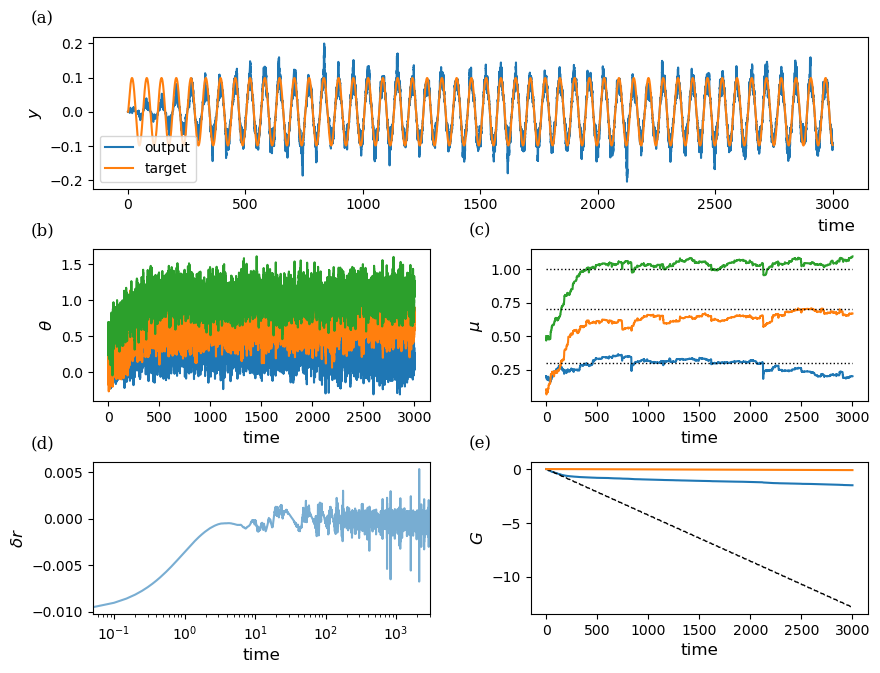

In [8]:

# Updates 3 sets of parameters: (i) input to hidden state, (ii) recurrent hidden state, (iii) readout
def diffusive_learning_recurrent(net_structure, control_fun, reward_fun, y0, dt=0.05, t0=0, t1=150.0, epsilon=1.0, lambd=10.0, sigma=0.05, eta=1.0, key=jr.PRNGKey(0), target_fun=None):

    @eqx.filter_jit
    def drift_fun(t, y, args):
        '''
            Return deterministic values:
             1) dr̄ = ε(r-r̄) dt
             2) dz = tanh(θ1*z+θ2*x)
             3) dztg = tanh(θ1tg*ztg+θ2tg*x)
             4) dθ1 = λ(μ1-θ1)
             5) dμ1 = η(r-r̄)(θ1-μ1)
             6) dθ2 = λ(μ2-θ2)
             7) dμ2 = η(r-r̄)(θ2-μ2)
             8) dθ3 = λ(μ3-θ3)
             9) dμ3 = η(r-r̄)(θ3-μ3)
             10) dr = r -> Cumulative reward
        '''

        # Extract params from the input (we need the squeeze idk why)
        M = net_structure[0]
        rbar = y[0]           
        z = y[1] 
        z_gt = y[2] 
        theta1 = jnp.squeeze(y[3:(M+3)])
        mu1 = jnp.squeeze(y[(M+3):(2*M+3)])
        theta2 = jnp.squeeze(y[(2*M+3):(2*M+4)])     
        mu2 = jnp.squeeze(y[(2*M+4):(2*M+5)])  
        theta3 = jnp.squeeze(y[(2*M+5):(2*M+6)])     
        mu3 = jnp.squeeze(y[(2*M+6):(2*M+7)])  
        gain = y[-1]      
        
        
        # Deterministic part
        if target_fun is None: # Given target parameters
            control_fun = args[0]
            [theta1_gt, theta2_gt, theta3_gt] = [0.3, 0.7, 1.0]
            x = control_fun(t) # Input
            r = reward_fun(theta3 * z, theta3_gt * z_gt, t)
            return jnp.array([epsilon * (r - rbar),
                            tanh(theta1 * z + theta2 * x) - z,
                            tanh(theta1_gt * z_gt + theta2_gt * x) - z_gt,
                            lambd * (mu1 - theta1), 
                            eta * (r - rbar) * (theta1 - mu1),
                            lambd * (mu2 - theta2), 
                            eta * (r - rbar) * (theta2 - mu2),
                            lambd * (mu3 - theta3), 
                            eta * (r - rbar) * (theta3 - mu3),
                            r                        
                            ])
        else: # Given target output
            control_fun = args[0]
            x = control_fun(t) # Input
            r = reward_fun(z, theta3, args[1](t))
            return jnp.array([epsilon * (r - rbar),
                            tanh(theta1 * z + theta2 * x) - z,
                            0,
                            lambd * (mu1 - theta1), 
                            eta * (r - rbar) * (theta1 - mu1),
                            lambd * (mu2 - theta2), 
                            eta * (r - rbar) * (theta2 - mu2),
                            lambd * (mu3 - theta3), 
                            eta * (r - rbar) * (theta3 - mu3),
                            r                        
                            ])

    # # Variable dimension in theta and mu
    M = net_structure[0]

    # Wiener process (random noise)
    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(M+2,), key=key)

    # Apply noise to theta 
    D1 = jnp.vstack([jnp.zeros(M), jnp.zeros(M), jnp.zeros(M), sigma * jnp.eye(M), jnp.zeros((M, M)), jnp.zeros(M), jnp.zeros(M), jnp.zeros(M), jnp.zeros(M), jnp.zeros(M)]) 
    D2 = jnp.vstack([jnp.zeros(1), jnp.zeros(1), jnp.zeros(1), jnp.zeros((M, 1)), jnp.zeros((M, 1)), sigma * jnp.ones(1), jnp.zeros(1), jnp.zeros(1), jnp.zeros(1), jnp.zeros(1)]) 
    D3 = jnp.vstack([jnp.zeros(1), jnp.zeros(1), jnp.zeros(1), jnp.zeros((M, 1)), jnp.zeros((M, 1)), jnp.zeros(1), jnp.zeros(1), sigma * jnp.ones(1), jnp.zeros(1), jnp.zeros(1)]) 
    D = jnp.hstack([D1, D2, D3])
    diffusion_fun = lambda t, y, args: D
    terms = MultiTerm(ODETerm(drift_fun), ControlTerm(diffusion_fun, brownian_motion))

    # Numerical integration to simulate system
    solver = EulerHeun()
    if target_fun is None:
        sol = diffeqsolve(terms, solver, t0=t0, t1=t1, dt0=dt, y0=y0, saveat=dfx.SaveAt(steps=True), args=[control_fun], max_steps=100000)
    else:
        sol = diffeqsolve(terms, solver, t0=t0, t1=t1, dt0=dt, y0=y0, saveat=dfx.SaveAt(steps=True), args=[control_fun, target_fun], max_steps=300000)

    # Remove infinite values from the solution
    ts = sol.ts[~jnp.isinf(sol.ts)]
    ys = sol.ys[~jnp.isinf(sol.ts), :]

    return ts, ys


# Reward function
@jax.jit
def reward_fun(y, y_gt, t):
    return -(y - y_gt) ** 2


# we drive the system with a sine wave; that is u is the input x 
control_fun= lambda t: 1e-1 * jnp.sin(0.1*t)


# Initial conditions
net_structure = [1, 1, 1]
thetas_gt = [0.3, 0.7, 1.0]
thetas0 = [0.2, 0.1, 0.5]
mus0 = thetas0
rbar0 = 0.01 #0.0
z0 = 0.0
z_gt0 = 0.0
y0 = jnp.array([rbar0, z0, z_gt0, thetas0[0], mus0[0], thetas0[1], mus0[1], thetas0[2], mus0[2], 0.0])
t1 = 3000
sigma = 0.2 #0.2


#Learning
ts, ys = diffusive_learning_recurrent(net_structure=net_structure, control_fun=control_fun, reward_fun=reward_fun, y0=y0, dt=0.05, t0=0, t1=t1, epsilon=1.0, lambd=1.0, sigma=sigma, eta=50.0, key=jr.PRNGKey(0))
rbar, z, z_gt, theta1, mu1, theta2, mu2, theta3, mu3, gain = [ys[:, i] for i in range(10)]


# Generate plot
fig = plt.figure(figsize=(10, 7.5))
grid = plt.GridSpec(3, 2, height_ratios=[2, 2, 2], hspace=0.4, wspace=0.3)


# Plot pred. output vs target output
ax0 = fig.add_subplot(grid[0, :2])  # Spanning the first 2 columns and 1 row
ax0.plot(ts, theta3 * z, label='output')
ax0.plot(ts, thetas_gt[2] * z_gt, label='target')
ax0.set_ylabel(r'$y$', fontsize=12)
ax0.set_xlabel('time', rotation=0, fontsize=12)
ax0.xaxis.set_label_coords(0.96, -0.2)
ax0.text(0.0, 1.0, '(a)', transform=(
    ax0.transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')
ax0.legend()


# Plot thetas
ax1 = fig.add_subplot(grid[1, 0])
ax1.plot(ts, theta1, label='theta1')
ax1.plot(ts, theta2, label='theta2')
ax1.plot(ts, theta3, label='theta3')
ax1.set_ylabel(r'$\theta$', fontsize=12)
ax1.set_xlabel('time', rotation=0, fontsize=12)
ax1.text(0.0, 1.0, '(b)', transform=(
    ax1.transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')


# Plot mus
ax2 = fig.add_subplot(grid[1, 1])
ax2.plot(ts, mu1, label='mu1')
ax2.plot(ts, mu2, label='mu2')
ax2.plot(ts, mu3, label='mu3')
ax2.hlines(y=thetas_gt, xmin=0, xmax=ts[-1], linewidth=1, color='black', linestyle='dotted', label='targets')
ax2.set_ylabel(r'$\mu$', fontsize=12)
ax2.set_xlabel('time', rotation=0, fontsize=12)
ax2.text(0.0, 1.0, '(c)', transform=(
    ax2.transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')


# Plot RPE
ax3 = fig.add_subplot(grid[2, 0])
ax3.set_xlim(ts[0], ts[-1])
ax3.set_xlabel('time', rotation=0, fontsize=12)
rpe = jax.vmap(lambda t, pred, target: reward_fun(pred, target, t))(ts, theta3 * z, thetas_gt[2] * z_gt) - ys[:, 0]
ax3.semilogx(ts, rpe, lw=1.5, label=r'$\delta_r$', alpha=alpha_level)
ax3.set_ylabel(r'$\delta r$', fontsize=12)
ax3.set_xlabel('time', rotation=0, fontsize=12)
ax3.text(0.0, 1.0, '(d)', transform=(
    ax3.transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')


# Plot cumulative reward
ax4 = fig.add_subplot(grid[2, 1])
ax4.plot(ts, gain, label='trained (theta)') # Trained with theta
ts, ysn = diffusive_learning_recurrent(net_structure, control_fun, reward_fun, y0, dt=0.05, t0=0, t1=t1, epsilon=0.0, lambd=0.0, sigma=0.0, eta=0.0, key=jr.PRNGKey(0)) # Non-trained
ax4.set_ylabel(r'$G$', fontsize=12)
ax4.set_xlabel('time', rotation=0, fontsize=12)
ax4.plot(ts, ysn[:, -1],  'k--', lw=1, label='untrained')
y0 = jnp.array([rbar0, z0, z_gt0, mu1[-1], mu1[-1], mu2[-1], mu2[-1], mu3[-1], mu3[-1], 0.0])
ts, ysm = diffusive_learning_recurrent(net_structure, control_fun, reward_fun, y0, dt=0.05, t0=0, t1=t1, epsilon=0.0, lambd=0.0, sigma=0.0, eta=0.0, key=jr.PRNGKey(0)) # Mus = thethas
ax4.plot(ts, ysm[:, -1], label='trained (mu)') # Trained with theta
ax4.text(0.0, 1.0, '(e)', transform=(
    ax4.transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')


# Final stuff
plt.tight_layout()
plt.savefig(media+'1D_recurrent.pdf', format='pdf')




## 3. Learning a multi-parameter model

### Learn parameters in a multi-input model

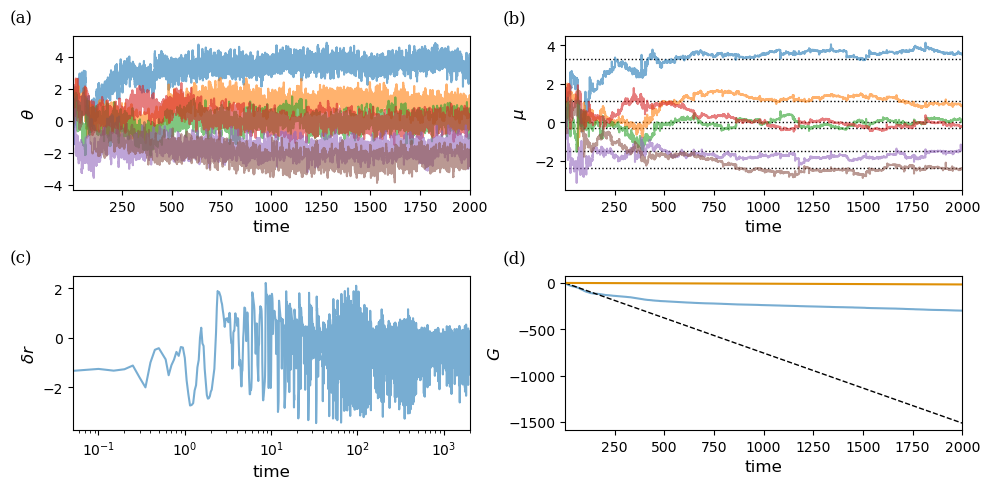

In [97]:


theta_gt = jnp.array([3.3, 1.1, 0.0, -0.3, -1.5, -2.4]) 

# Reward function
@jax.jit
def reward_fun(u, theta, t):
    return -(tanh(u @ theta) - tanh(u @ theta_gt)) ** 2


# Control input function - sin wave
num_inputs = 6
control_fun = lambda t: jnp.sin(jnp.arange(1, num_inputs + 1) * t + jnp.linspace(0, 2 * jnp.pi, num_inputs, endpoint=False))


# Initial conditions
rbar0 = 1.0
theta0 = jnp.zeros(num_inputs)
mu0 = theta0
y0 = jnp.hstack([rbar0, theta0, mu0, 0.0]) 
t1 = 2000  


# Simulate diffusive learning process
ts, ys = diffusive_learning(control_fun, reward_fun, y0, t0=0, t1=t1, key=jr.PRNGKey(1))  # Epsilon set to 1 for stability
rbar, theta, mu, gain = [ys[:, i] for i in range(4)]

# Create plots
fig, ax = plt.subplots(2, 2, figsize=(10, 5))


# Plot theta evolution
ax[0, 0].plot(ts, ys[:, 1:(num_inputs + 1)], lw=1.5, alpha=alpha_level)
ax[0, 0].set_xlim(ts[0], ts[-1])
ax[0, 0].set_xlabel('time', rotation=0, fontsize=12)
ax[0, 0].set_ylabel(r'$\theta$', fontsize=12)
ax[0, 0].text(0.0, 1.0, '(a)', transform=(
    ax[0, 0].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')


# Plot mu evolution
ax[0, 1].hlines(y=theta_gt, xmin=0, xmax=ts[-1], linewidth=1, color='black', linestyle='dotted', label='targets')
ax[0, 1].plot(ts, ys[:, (num_inputs + 1):(2 * num_inputs + 1)], lw=1.5, alpha=alpha_level)
ax[0, 1].set_xlim(ts[0], ts[-1])
ax[0, 1].set_xlabel('time', rotation=0, fontsize=12)
ax[0, 1].set_ylabel(r'$\mu$', fontsize=12)
ax[0, 1].text(0.0, 1.0, '(b)', transform=(
    ax[0, 1].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')


# Plot reward differential
reward_differential = jax.vmap(lambda t, theta: reward_fun(control_fun(t), theta, t))(ts, ys[:, 1:(num_inputs + 1)]) - ys[:, 0]
ax[1, 0].semilogx(ts, reward_differential, lw=1.5, label=r'$\delta r$', alpha=alpha_level)
ax[1, 0].set_xlabel('time', rotation=0, fontsize=12)
ax[1, 0].set_xlim(ts[0], ts[-1])
ax[1, 0].set_ylabel(r'$\delta r$', fontsize=12)
ax[1, 0].text(0.0, 1.0, '(c)', transform=(
    ax[1, 0].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')


# Plot cumulative reward
ax[1, 1].plot(ts, ys[:, -1], lw=1.5, alpha=alpha_level)
ax[1, 1].set_xlim(ts[0], ts[-1])

# Compute gain without learning
ts, ys0 = diffusive_learning(control_fun, reward_fun, y0, t0=0, t1=t1, epsilon=0, lambd=0.0, sigma=0.0, eta=0.0, key=jr.PRNGKey(1))
ax[1, 1].plot(ts, ys0[:, -1], 'k--', lw=1)
ax[1, 1].text(0.0, 1.0, '(d)', transform=(
    ax[1, 1].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')

# Use the mean value (mu) for the parameters (theta)
rbar0 = 1.0
theta0 = ys[-1, (num_inputs + 1):(2 * num_inputs + 1)]  # Final mu parameters
mu0 = theta0
y0 = jnp.hstack([rbar0, theta0, mu0, 0.0])
ts, ysf = diffusive_learning(control_fun, reward_fun, y0, t0=0, t1=t1, epsilon=0, lambd=0.0, sigma=0.0, eta=0.0, key=jr.PRNGKey(1))
ax[1, 1].plot(ts, ysf[:, -1], '-', lw=1.5, color=qcmap[1])

# Set final labels and save plot
ax[1, 1].set_ylabel(r"$G$", fontsize=12)
ax[1, 1].set_xlabel('time', rotation=0, fontsize=12)
plt.tight_layout()
plt.savefig(media + 'multivariate_input.pdf', format='pdf')


## 4. Weather prediction task

### Training and validation on ZCA-decorrelated data

In [5]:

# Generate dataset
decorrelation = True
delay_pred = 24
split_indx = 90000
(x_train, y_train), (x_test, y_test), features_names, data_mean, data_std = generate_weather_data(delay_pred=delay_pred, split_indx=split_indx, decorrelation=decorrelation)


# Check that it's all good
print(features_names)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)


# Interpolation samples (discrete to continuous data)
time_scale = 1.0 
ts = jnp.arange(0, len(x_train), time_scale)
coeffs = dfx.backward_hermite_coefficients(ts, x_train)
u_interp = dfx.CubicInterpolation(ts, coeffs)
control_fun = lambda t: u_interp.evaluate(t)


# Interpolation labels (discrete to continuous data)
ts = jnp.arange(0, len(y_train), time_scale)
coeffs = dfx.backward_hermite_coefficients(ts, y_train)
target_interp = dfx.CubicInterpolation(ts, coeffs)
target_fun = lambda t: target_interp.evaluate(t)


# Reward function
@jax.jit  
def reward_fun(u, theta, target):  
    return -(u @ theta - target) ** 2  


# Initial stuff
num_inputs = x_train.shape[1]
rbar0 = 1.0  
theta0 = 1e-3 * jr.normal(jr.PRNGKey(0), (num_inputs,))  # Params. init
mu0 = theta0  
y0 = jnp.hstack([rbar0, theta0, mu0, 0.0])
t1 = 3500
epsilon = 2.0
sigma = 0.04


# Learning
ts, ys = diffusive_learning(control_fun, reward_fun, y0, target_fun=target_fun, epsilon=epsilon, sigma=sigma, t0=0, t1=t1, key=jr.PRNGKey(0))
theta_opt = ys[-1, (num_inputs + 1):(2 * num_inputs + 1)]  # Final mu values (optimal thetas)


# Interpolation samples (discrete to continuous data)
ts2 = jnp.arange(0, len(x_test), time_scale)
coeffs2 = dfx.backward_hermite_coefficients(ts2, x_test)
u_interp2 = dfx.CubicInterpolation(ts2, coeffs2)
control_fun2 = lambda t: u_interp2.evaluate(t)

# Interpolation labels (discrete to continuous data)
ts2 = jnp.arange(0, len(y_test), time_scale)
coeffs2 = dfx.backward_hermite_coefficients(ts2, y_test)
target_interp2 = dfx.CubicInterpolation(ts2, coeffs2)
target_fun2 = lambda t: target_interp2.evaluate(t)


# Predictions
y_pred = jax.vmap(lambda t: control_fun2(t) @ theta_opt)(ts2) * data_std[0] + data_mean[0]
y_true = jax.vmap(target_fun2)(ts2) * data_std[0] + data_mean[0]
y_init = jax.vmap(lambda t: control_fun2(t) @ theta0)(ts2) * data_std[0] + data_mean[0]


['Temperature (C)', 'Relative humidity', 'Wind speed (km/h)', 'Sine wind bearing', 'Cosine wind bearing', 'Pressure (millibars)']
(90000, 6) (6429, 6)
(90000,) (6429,)


### Training and validation on original data

In [6]:

# Generate dataset
decorrelation = False
delay_pred = 24
split_indx = 90000
(x_train_nd, y_train_nd), (x_test_nd, y_test_nd), features_names, data_mean_nd, data_std_nd = generate_weather_data(delay_pred=delay_pred, split_indx=split_indx, decorrelation=decorrelation)


# Interpolation samples (discrete to continuous data)
time_scale = 1.0 
ts_nd = jnp.arange(0, len(x_train_nd), time_scale)
coeffs_nd = dfx.backward_hermite_coefficients(ts_nd, x_train_nd)
u_interp_nd = dfx.CubicInterpolation(ts_nd, coeffs_nd)
control_fun_nd = lambda t: u_interp_nd.evaluate(t)


# Interpolation labels (discrete to continuous data)
ts_nd = jnp.arange(0, len(y_train_nd), time_scale)
coeffs_nd = dfx.backward_hermite_coefficients(ts_nd, y_train)
target_interp_nd = dfx.CubicInterpolation(ts_nd, coeffs_nd)
target_fun_nd = lambda t: target_interp_nd.evaluate(t)


# Initial stuff
num_inputs = x_train_nd.shape[1]
rbar0 = 1.0  
theta0 = 1e-3 * jr.normal(jr.PRNGKey(0), (num_inputs,))  # Params. init
mu0 = theta0  
y0 = jnp.hstack([rbar0, theta0, mu0, 0.0])


# Learning
ts_nd, ys_nd = diffusive_learning(control_fun_nd, reward_fun, y0, target_fun=target_fun_nd, epsilon=epsilon, sigma=sigma, t0=0, t1=t1, key=jr.PRNGKey(0))
theta_opt_nd = ys_nd[-1, (num_inputs + 1):(2 * num_inputs + 1)]  # Final mu values (optimal thetas)


# Interpolation samples (discrete to continuous data)
ts2_nd = jnp.arange(0, len(x_test_nd), time_scale)
coeffs2_nd = dfx.backward_hermite_coefficients(ts2_nd, x_test_nd)
u_interp2_nd = dfx.CubicInterpolation(ts2_nd, coeffs2_nd)
control_fun2_nd = lambda t: u_interp2_nd.evaluate(t)

# Interpolation labels (discrete to continuous data)
ts2_nd = jnp.arange(0, len(y_test_nd), time_scale)
coeffs2_nd = dfx.backward_hermite_coefficients(ts2_nd, y_test_nd)
target_interp2_nd = dfx.CubicInterpolation(ts2_nd, coeffs2_nd)
target_fun2_nd = lambda t: target_interp2_nd.evaluate(t)


# Predictions
y_pred_nd = jax.vmap(lambda t: control_fun2_nd(t) @ theta_opt_nd)(ts2_nd) * data_std[0] + data_mean[0]
y_true_nd = jax.vmap(target_fun2)(ts2) * data_std[0] + data_mean[0]
y_init_nd = jax.vmap(lambda t: control_fun2(t) @ theta0)(ts2) * data_std[0] + data_mean[0]

### Plots

Corr. coefficient ZCA data:
[[0.99999994 0.83538836]
 [0.83538836 1.        ]]
[[0.99999994 0.02070407]
 [0.02070407 1.        ]]
Corr. coefficient original data:
[[0.99999994 0.79306966]
 [0.79306966 0.99999994]]
[[0.99999994 0.02070407]
 [0.02070407 1.        ]]


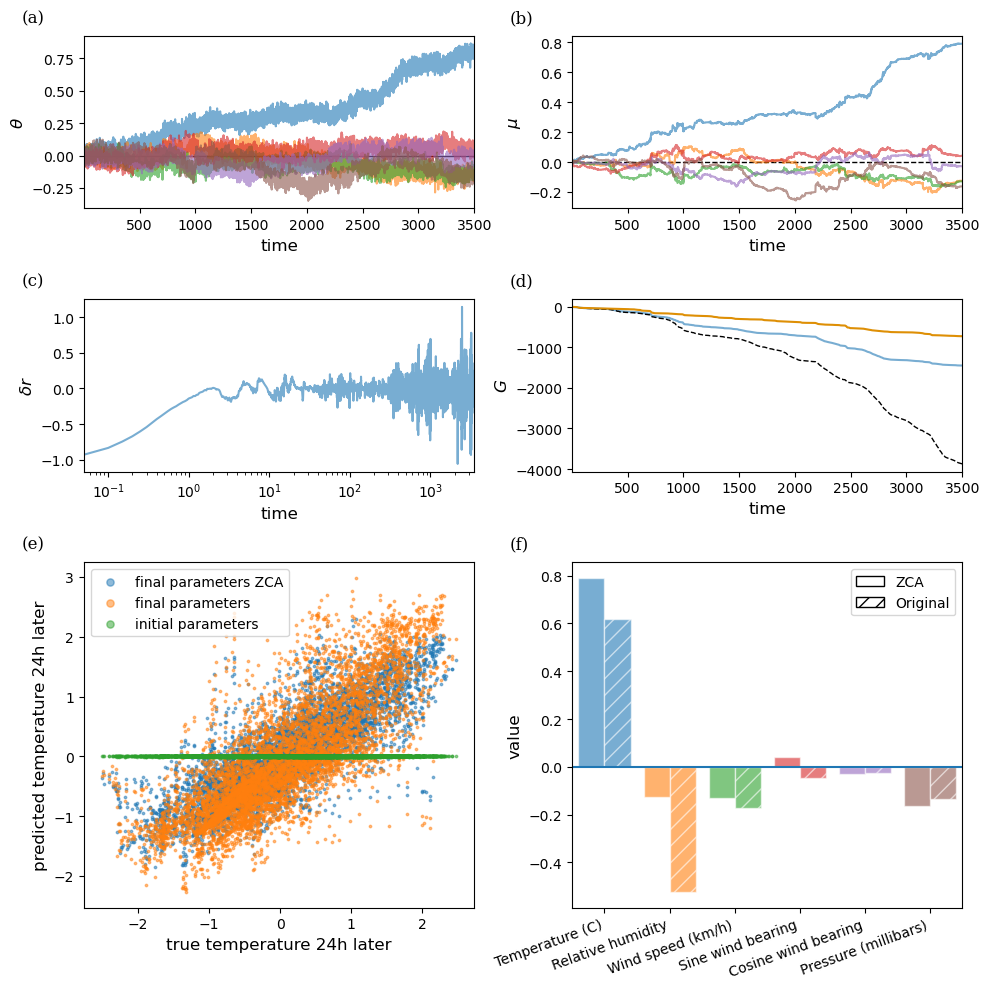

In [7]:

from matplotlib.patches import Patch


# Create plot
fig, ax = plt.subplots(3,2, figsize=(10,10), gridspec_kw={'height_ratios': [1, 1, 2]})


# Plot thetas
ax[0,0].plot([ts[0], ts[-1]], [0.0, 0.0], 'k-', lw=1)
ax[0,0].plot(ts, ys[:, 1:(num_inputs+1)], lw=1.5, alpha=alpha_level)
ax[0,0].set_xlim(ts[0], ts[-1])
ax[0,0].set_xlabel('time', rotation=0, fontsize=12)
ax[0,0].set_ylabel(r'$\theta$', fontsize=12)
ax[0,0].text(0.0, 1.0, '(a)', transform=(
    ax[0,0].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')


# Plot mus
ax[0,1].plot([ts[0], ts[-1]], [0.0, 0.0], 'k--', lw=1)
ax[0,1].plot(ts, ys[:, (num_inputs+1):(2*num_inputs+1)], lw=1.5, alpha=alpha_level)
ax[0,1].set_xlim(ts[0], ts[-1])
ax[0,1].set_xlabel('time', rotation=0, fontsize=12)
ax[0,1].set_ylabel(r'$\mu$', fontsize=12)
ax[0,1].text(0.0, 1.0, '(b)', transform=(
    ax[0,1].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')


# Plot RPE
ax[1,0].set_xlim(ts[0], ts[-1])
reward_differential = jax.vmap(lambda t, theta: reward_fun(control_fun(t), theta, target_fun(t)))(ts, ys[:, 1:(num_inputs+1)]) - ys[:, 0]
ax[1,0].set_xlabel('time', rotation=0, fontsize=12)
# ax[1,0].plot(ts, reward_differential, lw=1.5, label=r'$\delta_r$', alpha=alpha_level)
ax[1,0].semilogx(ts, reward_differential, lw=1.5, label=r'$\delta_r$', alpha=alpha_level)
ax[1,0].set_ylabel(r'$\delta r$', fontsize=12)
ax[1,0].text(0.0, 1.0, '(c)', transform=(
    ax[1,0].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')


# Plot cumulative reward
ax[1, 1].plot(ts, ys[:, -1], lw=1.5, alpha=alpha_level) # using theta parameters
ax[1, 1].set_xlim(ts[0], ts[-1])  

# Prediction with no learning
ts, ys0 = diffusive_learning(control_fun, reward_fun, y0, target_fun=target_fun, t0=0, t1=t1, epsilon=0, lambd=0.0, sigma=0.0, eta=0.0, key=jr.PRNGKey(0))
ax[1,1].plot(ts, ys0[:,-1], 'k--', lw=1)
ax[1,1].text(0.0, 1.0, '(d)', transform=(
    ax[1,1].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')

# Using mu as theta parameters
rbar0 = 1.0  
thetaf = ys[-1, (num_inputs + 1):(2 * num_inputs + 1)] 
muf = thetaf  
y0 = jnp.hstack([rbar0, thetaf, muf, 0.0])  
ts, ysf = diffusive_learning(control_fun, reward_fun, y0, target_fun=target_fun, t0=0, t1=t1, epsilon=0, lambd=0.0, sigma=0.0, eta=0.0, key=jr.PRNGKey(0))
ax[1,1].plot(ts, ysf[:,-1], '-', lw=1.5, color=qcmap[1])
ax[1,1].set_ylabel(r"$G$", fontsize=12)
ax[1,1].set_xlabel('time', rotation=0, fontsize=12)


# Scatter plot for true vs predicted temperatures
ax[2,0].scatter(y_true, y_pred, s=3, alpha=0.5)
ax[2,0].scatter(y_true_nd, y_pred_nd, s=3, alpha=0.5)
ax[2,0].scatter(y_true, y_init, s=3, alpha=0.5)
ax[2,0].legend([r'final parameters ZCA', r'final parameters', r'initial parameters'], markerscale=3)
ax[2,0].set_xlabel('true temperature 24h later', rotation=0, fontsize=12)
ax[2,0].set_ylabel('predicted temperature 24h later', fontsize=12)
ax[2,0].text(0.0, 1.0, '(e)', transform=(
    ax[2,0].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')



# Combine data from both sets into one DataFrame
data = pd.DataFrame(dict(
    theta_opt = theta_opt,
    theta_opt_nd = theta_opt_nd,
    labels = features_names
)).melt(id_vars=['labels'], value_vars=['theta_opt', 'theta_opt_nd'], 
        var_name='Set', value_name='Value')

# Create bar plot with two bars per feature (one for each value set)
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
sns.barplot(x='labels', y='Value', hue='Set', data=data, ax=ax[2,1], 
            palette=palette, alpha=alpha_level)  # Use color palette for unique feature colors

# Manually set face colors for the bars
for bars, colors in zip(ax[2, 1].containers, (palette[:], palette[:])):
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)

# Set different hatch patterns to differentiate the value sets
hatch_patterns = ['', '//']  # Solid for one set, dashed for another
for bars, pattern in zip(ax[2,1].containers, hatch_patterns):
    for bar in bars:
        bar.set_hatch(pattern)
        bar.set_edgecolor('white')  # Change edge color to white for better visibility of hatch patterns

# Customize plot appearance
plt.xticks(rotation=30, horizontalalignment='right')
ax[2,1].set_xlabel('')
ax[2,1].axhline(0)
ax[2,1].set_ylabel('value', fontsize=12)
ax[2,1].text(0.0, 1.0, '(f)', transform=(
    ax[2,1].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')

# Create a custom legend that matches the hatch patterns in the bar plots
handles = [
    Patch(facecolor='white', edgecolor='black', label='ZCA', hatch=''),      # Solid hatch for theta_opt
    Patch(facecolor='white', edgecolor='black', label='Original', hatch='//') # Dashed hatch for theta_opt_nd
]

ax[2, 1].legend(handles=handles, loc='upper right')
ax[2,1].tick_params(axis='x', labelrotation=20)



# Final stuff
plt.tight_layout()
plt.savefig(media+'weather_combined.pdf', format='pdf')
    


print('Corr. coefficient ZCA data:')
print(jnp.corrcoef(y_true, y_pred))
print(jnp.corrcoef(y_true, y_init))

print('Corr. coefficient original data:')
print(jnp.corrcoef(y_true_nd, y_pred_nd))
print(jnp.corrcoef(y_true_nd, y_init_nd))

## 5. Learning to control a stochastic double integrator


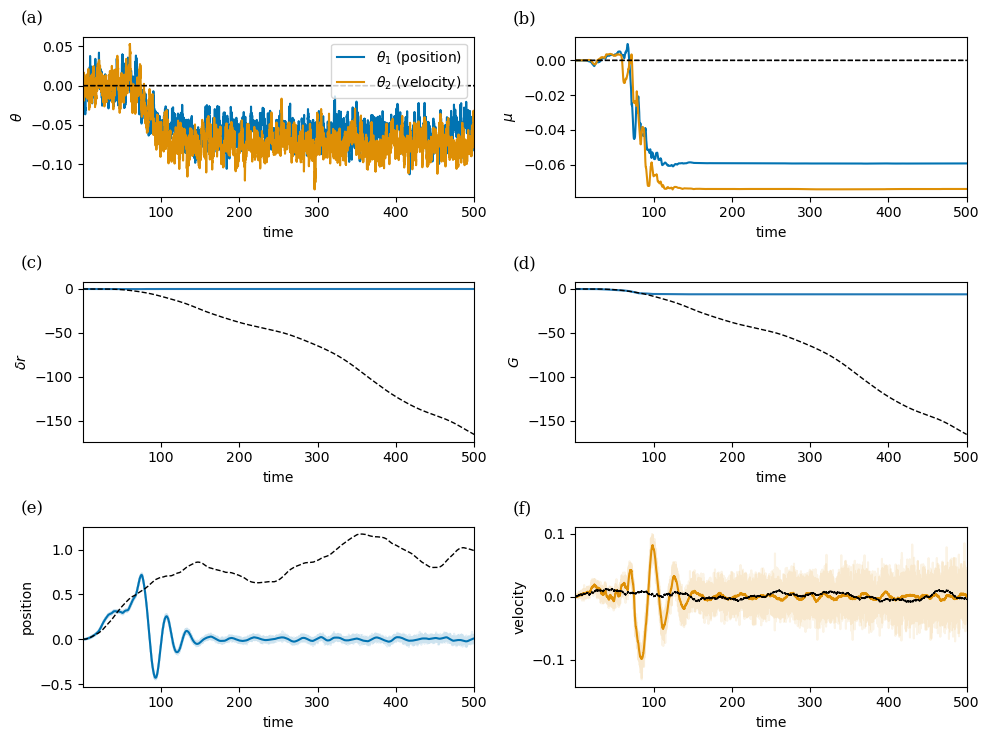

In [152]:

num_states = 2

# Observed state function
@jax.jit
class ObsFun(eqx.Module):

    noise_level = 0.001
    obs_noise = UnsafeBrownianPath(shape=(num_states,), key=jr.PRNGKey(42))

    def __call__(self, x, t):
        return x + self.noise_level * self.obs_noise.evaluate(t)



# reward function
@jax.jit
def reward_fun(x, u):
    # quadratic cost
    return -0.5 * jnp.linalg.norm(x)**2 - 0.5 * u ** 2



# Learning function which adds noise to parameters and observed states
def coupled_learning(obs_fun, reward_fun, y0, dt=0.05, t0=0, t1=200, lambd=1.0, sigma=0.02, epsilon=2.0, eta=50.0, friction=0.01, process_noise=0.001, key=jr.PRNGKey(0)):

    @eqx.filter_jit
    def drift_fun(t, y, args):
        '''
            Return deterministic drift values:
            1) dr̄ = ε(r - r̄) -> update the estimated reward.
            2) dr = r -> current reward.
            3) d(Δr) = r - r̄ -> error between actual reward and estimated reward.
            4) dθ = λ(μ - θ) -> update control parameters (θ) based on the difference between θ and μ.
            5) dμ = η(r - r̄)(θ - μ) -> update μ based on reward error and control parameters.
            6) d(states) -> state evolution based on control and friction.
        '''
        rbar, gain, deltar, thetas, mus, states = y

        # Observation vector (position and velocity)
        obs = obs_fun(states, t) 

        # Control signal (acceleration)
        control_output = thetas @ obs.T 

        # Reward
        r = reward_fun(states, control_output)

        return (epsilon * (r - rbar),
                r,
                r - rbar,
                lambd * (mus - thetas),
                eta * (r - rbar) * (thetas - mus),
                jnp.array([states[1], -friction * states[1] + control_output]))


    # Number of parameters
    num_params = y0[3].size

    # Stochastic part (diffusion term for the ODE solver)
    diffusion_fun = lambda t, y, args: (0.0, 0.0, 0.0, sigma * jnp.eye(num_params), jnp.zeros(num_params), jnp.array([[0.0, process_noise]]).T)

    # Keys (seeds)
    keys = jr.split(key, 2)
    
    # Brownian motions for parameter and state (random noise)
    class BrownianMotions(eqx.Module):
        param_noise = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(num_params,), key=keys[0])
        state_noise = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(1,), key=keys[1])

        # Evaluate the Brownian motion at time t0 (or between t0 and t1) for both parameter and state noise.
        def __call__(self, t0, t1=None):
            return (0.0, 0.0, 0.0, self.param_noise.evaluate(t0, t1), jnp.zeros(num_params), self.state_noise.evaluate(t0, t1)) 
    bms = BrownianMotions()
    noise_func = ControlTerm(diffusion_fun, bms)
    terms = MultiTerm(ODETerm(drift_fun), noise_func)

    # Numerical integration to simulate the system
    sol = diffeqsolve(terms, EulerHeun(), t0, t1, dt0=dt, y0=y0, saveat=dfx.SaveAt(steps=True), max_steps=200000)

    # Remove infinite values from the solution
    ts = sol.ts[~jnp.isinf(sol.ts)]
    ys = tuple([ys[~jnp.isinf(sol.ts)] for ys in sol.ys])

    return ts, ys


# Initial stuff
num_params = 2
# num_states = 2
y0 = (0.0, 0.0, 0.0, jnp.zeros(num_params), jnp.zeros(num_params), jnp.zeros(num_states))
obs_fun = ObsFun()
t1 = 500


# Learning
ts, ys = coupled_learning(obs_fun, reward_fun, y0, t0=0, t1=t1, key=jr.PRNGKey(0))


# Generate plot
fig, ax = plt.subplots(3,2, figsize=(10, 7.5))

# Plot theta
ax[0,0].plot(ts, ys[3][:,0], color=qcmap[0])
ax[0,0].plot(ts, ys[3][:,1], color=qcmap[1])
ax[0,0].set_ylabel(r'$\theta$');
ax[0,0].set_xlabel('time')
ax[0,0].legend([r'$\theta_1$ (position)', r'$\theta_2$ (velocity)'], loc="upper right")
ax[0,0].set_xlim(ts[0], ts[-1])
ax[0,0].text(0.0, 1.0, '(a)', transform=(
    ax[0,0].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')

# Plot mu
ax[0,1].plot(ts, ys[4][:,0], color=qcmap[0])
ax[0,1].plot(ts, ys[4][:,1], color=qcmap[1])
ax[0,1].set_ylabel(r'$\mu$')
ax[0,1].set_xlabel('time')
ax[0,1].set_xlim(ts[0], ts[-1])
ax[0,1].text(0.0, 1.0, '(b)', transform=(
    ax[0,1].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')

# Plot RPE
ax[1,0].plot(ts, ys[2])
ax[1,0].set_ylabel(r'$\delta {r}$')
ax[1,0].set_xlabel('time')
ax[1,0].set_xlim(ts[0], ts[-1])
ax[1,0].text(0.0, 1.0, '(c)', transform=(
    ax[1,0].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')

# Plot cumulative reward
ax[1,1].plot(ts, ys[1])
ax[1,1].set_ylabel(r'$G$')
ax[1,1].set_xlabel('time')
ax[1,1].set_xlim(ts[0], ts[-1])
ax[1,1].text(0.0, 1.0, '(d)', transform=(
    ax[1,1].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')

# Plot particle position
ax[2,0].plot(ts, jax.vmap(obs_fun)(ys[5][:, 0], ts), color=qcmap[0], alpha=0.1) 
ax[2,0].plot(ts, ys[5][:,0], color=qcmap[0])
ax[2,0].set_ylabel('position')
ax[2,0].set_xlabel('time')
ax[2,0].set_xlim(ts[0], ts[-1])
ax[2,0].text(0.0, 1.0, '(e)', transform=(
    ax[2,0].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')

# Plot particle velocity
ax[2,1].plot(ts, jax.vmap(obs_fun)(ys[5][:, 1], ts), color=qcmap[1], alpha=0.1)
ax[2,1].plot(ts, ys[5][:, 1], color=qcmap[1])
ax[2,1].set_ylabel('velocity')
ax[2,1].set_xlabel('time')
ax[2,1].set_xlim(ts[0], ts[-1])
ax[2,1].text(0.0, 1.0, '(f)', transform=(
    ax[2,1].transAxes + ScaledTranslation(-45/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')

# Without learning - plot theta, mu, RPE, particle position, particle velocity
ts, ys = coupled_learning(obs_fun, reward_fun, y0, t0=0, t1=t1, lambd=0.0, sigma=0.0, epsilon=0.0, eta=0.0, key=jr.PRNGKey(0))
ax[0,0].plot(ts, ys[3][:,0], 'k--', lw=1)
ax[0,0].plot(ts, ys[3][:,1], 'k--', lw=1)
ax[0,1].plot(ts, ys[4][:,0], 'k--', lw=1)
ax[0,1].plot(ts, ys[4][:,1], 'k--', lw=1)
ax[1,0].plot(ts, ys[2], 'k--', lw=1)
ax[1,1].plot(ts, ys[1], 'k--', lw=1)
ax[2,0].plot(ts, ys[5][:,0], 'k--', lw=1)
ax[2,1].plot(ts, ys[5][:, 1], 'k--', lw=1)

# Final stuff
plt.tight_layout()
plt.savefig(media+'control_task.pdf', format='pdf')


## 6. Meta learning (with volatile theta target)


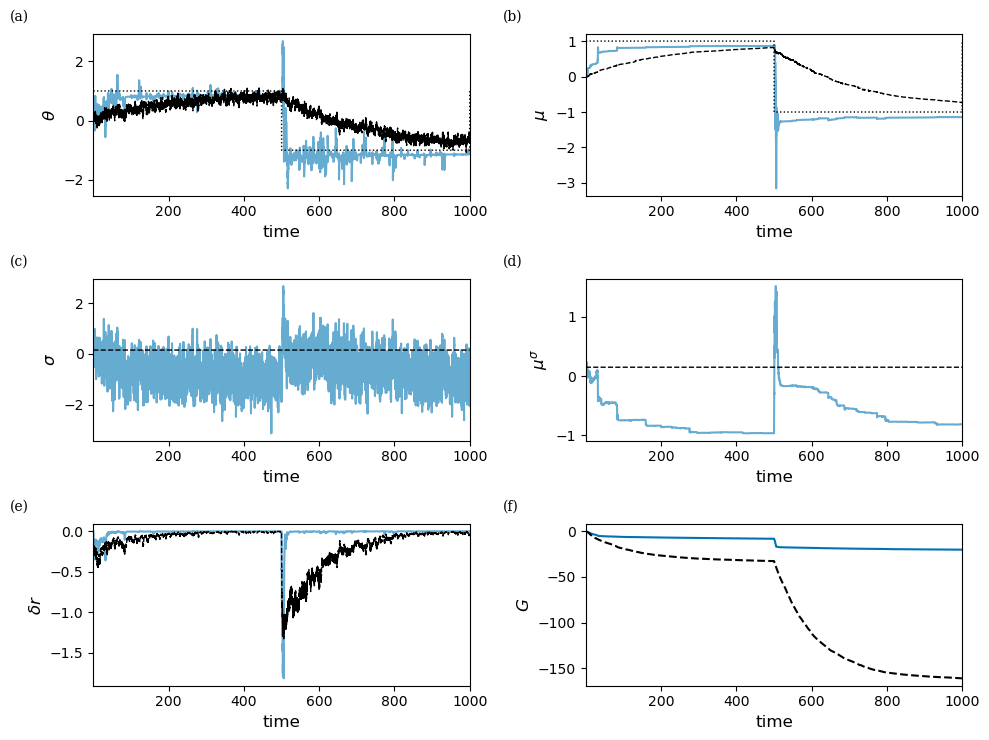

In [151]:

# Computes the target for each time step
@jax.jit
def target_fun(t):       
    return jnp.float32(2.0 * (jnp.mod(t, 1000) < 500) - 1.0)


# Reward function
@jax.jit
def reward_fun(u, theta, t):
    return  -(tanh(u * theta) - tanh(u * target_fun(t))) ** 2  


# we drive the system with a sine wave; that is u is the input x 
control_fun= lambda t: jnp.sin(10.0*t)


# Learning function adapted to learn sigma
def meta_learning(control_fun, reward_fun, y0, dt=0.05, t0=0, t1=200,
                       lambd=1.0, epsilon=1.0, eta=2.0,
                       lambd_sigma=2.0, rho=1.0, eta_sigma=3.0, 
                       key=jr.PRNGKey(0)):
    
    @eqx.filter_jit
    def drift_fun(t, y, args):
        '''
            Return deterministic drift values:
            1) dr̄ = ε(r - r̄) -> update the estimated reward.
            2) dθ = λ(μ - θ) -> update control parameters (θ) based on the difference between θ and μ.
            3) dμ = η(r - r̄)(θ - μ) -> update μ based on reward error and control parameters.
            4) dσ = λ_σ(μ_σ - σ) -> update sigma value.
            5) dμ_σ = η_σ(r - r̄)(σ - μ_σ) -> update mean of sigma value.
            6) dr = r -> current reward.
            7) d(Δr) = r - r̄ -> error between actual reward and estimated reward.
        '''
        rbar, theta, mu, sigma, mu_sigma, gain, deltar = y 
        control_fun = args[0]
        r = reward_fun(control_fun(t), theta, t)
        return jnp.array([epsilon * (r - rbar), 
                        lambd * (mu - theta),
                        eta * (r - rbar) * (theta - mu),
                        lambd_sigma * (mu_sigma - sigma), 
                        eta_sigma * (r - rbar) * (sigma - mu_sigma),
                        r,
                        r - rbar])


    # Stochastic part (diffusion term for the ODE solver)
    diffusion_fun = lambda t, y, args: jnp.array([[0.0, relu(y[3])+1e-8, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, rho, 0.0, 0.0, 0.0]]).T

    # Brownian motions for parameter (random noise)
    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(2,), key=key)
    terms = MultiTerm(ODETerm(drift_fun), ControlTerm(diffusion_fun, brownian_motion))
    solver = EulerHeun()

    # Numerical integration to simulate the system
    sol = diffeqsolve(terms, solver, t0, t1, dt0=dt, y0=y0, saveat=dfx.SaveAt(steps=True), args=[control_fun], max_steps=100000)

    # Remove infinite values from the solution
    ts = sol.ts[~jnp.isinf(sol.ts)]
    ys = sol.ys[~jnp.isinf(sol.ts), :]

    return ts, ys



# initial conditions
rbar0 = 0.0
theta0 = 0.0
mu0 = theta0
sigma0 = 0.15
mu_sigma0 = sigma0
y0 = jnp.array([rbar0, theta0, mu0, sigma0, mu_sigma0, 0.0, 0.0])
t1 = 1000 # 1000 #500


# Keys (seeds)
keys = jr.split(jr.PRNGKey(0), 15)
key = keys[0]


# Learning
ts, ys = meta_learning(control_fun, reward_fun, y0, t0=0, t1=t1, key=key)
rbars = ys[:, 0]
thetas = ys[:, 1]
mus = ys[:, 2]
sigmas = ys[:, 3]
musigmas = ys[:, 4]
cumreward = ys[:, 5]
deltars = ys[:, 6]


# Generate plot
fig, ax = plt.subplots(3,2, figsize=(10, 7.5))

# Plot theta
ax[0,0].plot(ts, thetas, color=qcmap[0], label=r"learnt $\sigma$", lw=1.5, alpha=alpha_level)
ax[0,0].set_xlim([ts[0], ts[-1]])
ax[0,0].set_xlabel('time', rotation=0, fontsize=12)
ax[0,0].set_ylabel(r"$\theta$", fontsize=12)
ax[0,0].text(0.0, 1.0, '(a)', transform=(
    ax[0,0].transAxes + ScaledTranslation(-60/72, +7/72, fig.dpi_scale_trans)),
    fontsize='medium', va='bottom', fontfamily='serif')

# Plot mu
ax[0,1].plot(ts, mus, color=qcmap[0], lw=1.5, alpha=alpha_level)
ax[0,1].set_xlim([ts[0], ts[-1]])
ax[0,1].set_xlabel('time', rotation=0, fontsize=12)
ax[0,1].set_ylabel(r"$\mu$", fontsize=12)
ax[0,1].text(0.0, 1.0, '(b)', transform=(
    ax[0,1].transAxes + ScaledTranslation(-60/72, +7/72, fig.dpi_scale_trans)),
    fontsize='medium', va='bottom', fontfamily='serif')

# Plot sigma
ax[1,0].plot(ts, sigmas, color=qcmap[0], lw=1.5, alpha=alpha_level)
ax[1,0].set_xlim([ts[0], ts[-1]])
ax[1,0].set_xlabel('time', rotation=0, fontsize=12)
ax[1,0].set_ylabel(r"$\sigma$", fontsize=12)
ax[1,0].text(0.0, 1.0, '(c)', transform=(
    ax[1,0].transAxes + ScaledTranslation(-60/72, +7/72, fig.dpi_scale_trans)),
    fontsize='medium', va='bottom', fontfamily='serif')

# Plot mu_sigma
ax[1,1].plot(ts, musigmas, color=qcmap[0], lw=1.5, alpha=alpha_level)
ax[1,1].set_xlim([ts[0], ts[-1]])
ax[1,1].set_xlabel('time', rotation=0, fontsize=12)
ax[1,1].set_ylabel(r"$\mu^\sigma$", fontsize=12)
ax[1,1].text(0.0, 1.0, '(d)', transform=(
    ax[1,1].transAxes + ScaledTranslation(-60/72, +7/72, fig.dpi_scale_trans)),
    fontsize='medium', va='bottom', fontfamily='serif')

# Plot RPE
ax[2,0].plot(ts, deltars, color=qcmap[0], lw=1.5, alpha=alpha_level)
ax[2,0].set_xlim([ts[0], ts[-1]])
ax[2,0].set_xlabel('time', rotation=0, fontsize=12)
ax[2,0].set_ylabel(r"$\delta{r}$", fontsize=12)
ax[2,0].text(0.0, 1.0, '(e)', transform=(
    ax[2,0].transAxes + ScaledTranslation(-60/72, +7/72, fig.dpi_scale_trans)),
    fontsize='medium', va='bottom', fontfamily='serif')

# Plot cumulative reward
ax[2,1].plot(ts, cumreward, color=qcmap[0], label=r"learnt $\sigma$", lw=1.5)
ax[2,1].set_xlim([ts[0], ts[-1]])
ax[2,1].set_xlabel('time', rotation=0, fontsize=12)
ax[2,1].set_ylabel(r"$G$", fontsize=12)
ax[2,1].text(0.0, 1.0, '(f)', transform=(
    ax[2,1].transAxes + ScaledTranslation(-60/72, +7/72, fig.dpi_scale_trans)),
    fontsize='medium', va='bottom', fontfamily='serif')

# Execution without learning the sigma (fixed)
ts0, ys0 = meta_learning(control_fun, reward_fun, y0, t0=0, t1=t1, lambd=1.0, epsilon=1.0, eta=1.0, lambd_sigma=0.0, rho=0.0, eta_sigma=0.0, key=key)
rbars0 = ys0[:, 0]
thetas0 = ys0[:, 1]
mus0 = ys0[:, 2]
sigmas0 = ys0[:, 3]
musigmas0 = ys0[:, 4]
cumreward0 = ys0[:, 5]
deltars0 = ys0[:, 6]
ax[0,0].plot(ts, thetas0, 'k--', label=r"constant $\sigma$", lw=1, alpha=1)
T = np.linspace(0, t1, int(t1/0.05))
opt_theta = np.array([target_fun(t) for t in T])
ax[0,0].plot(ts[:len(T)], opt_theta, 'k:', label=r"constant $\sigma$", lw=1, alpha=1)
ax[0,1].plot(ts, mus0, 'k--', lw=1, alpha=1)
ax[0,1].plot(ts[:len(T)], opt_theta, 'k:', label=r"constant $\sigma$", lw=1, alpha=1)
ax[1,0].plot(ts, sigma0 * jnp.ones(len(ts)), 'k--', lw=1, alpha=1)
ax[1,1].plot(ts, sigma0 * jnp.ones(len(ts)), 'k--', lw=1, alpha=1)
ax[2,0].plot(ts, deltars0, 'k--', lw=1, alpha=1)
ax[2,1].plot(ts, cumreward0, 'k--', label=r"constant $\sigma$", lw=1.5)

# Final plot stuff
plt.tight_layout()
plt.savefig('meta_learning.pdf', format='pdf')